In [6]:
!pip install playwright beautifulsoup4 pandas
!playwright install

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.4/39.4 MB 405.3 kB/s eta 0:00:0000:0100:03
  Attempting uninstall: greenlet
    Found existing installation: greenlet 3.0.1
    Uninstalling greenlet-3.0.1:
      Successfully uninstalled greenlet-3.0.1
129.7 MiB [                    ] 0% 8.3s129.7 MiB [                    ] 0% 41.5s129.7 MiB [                    ] 0% 43.3s129.7 MiB [                    ] 0% 39.7s129.7 MiB [                    ] 0% 40.4s129.7 MiB [                    ] 0% 38.1s129.7 MiB [                    ] 0% 33.6s129.7 MiB [                    ] 0% 32.2s129.7 MiB [                    ] 0% 30.4s129.7 MiB [                    ] 0% 28.2s129.7 MiB [                    ] 0% 27.2s129.7 MiB [                    ] 0% 25.2s129.7 MiB [                    ] 1% 23.6s129.7 MiB [                    ] 1% 20.5s129.7 MiB [                    ] 1% 19.7s129.7 MiB [                    ] 1% 18.1s129.7 MiB [                    ] 2% 17.0s129.7 MiB [                    ] 2% 16.0s129.7 MiB [= 

In [30]:
import asyncio
from playwright.async_api import async_playwright
import pandas as pd
import time

# 目标网址
URL = "https://dang.ai/ai-graveyard"

async def scrape_by_url_pattern():
    print(f"正在启动浏览器并访问: {URL}")
    print("策略：锁定 href包含 '/tool/' 的元素 -> 逆向提取描述")
    
    all_projects = []
    # 用于去重的集合，防止同一页抓到重复的
    seen_links = set()
    
    async with async_playwright() as p:
        # 开启浏览器界面，让你看到流程
        browser = await p.chromium.launch(headless=False) 
        page = await browser.new_page()
        
        await page.goto(URL, timeout=90000)
        
        print("首次加载，等待 10 秒...")
        await page.wait_for_timeout(10000)

        page_num = 1
        
        while True:
            print(f"\n=== 正在扫描第 {page_num} 页 ===")
            
            # 1. 缓慢滚动到底部，确保所有链接都加载出来
            # 即使是 Link 抓取，也需要元素渲染出来才能获取
            for _ in range(3):
                await page.mouse.wheel(0, 1000)
                await page.wait_for_timeout(1000)
            
            # 滚动回顶部，准备从头开始
            await page.evaluate("window.scrollTo(0, 0)")
            await page.wait_for_timeout(1000)

            # --- 核心逻辑：查找所有项目链接 ---
            # CSS选择器：a[href*='/tool/'] 表示 href 属性包含 '/tool/' 的所有 a 标签
            # 这能精准定位到每一个项目，绝无遗漏
            project_links = page.locator("a[href*='/tool/']")
            
            count = await project_links.count()
            print(f"本页共发现 {count} 个潜在项目链接。")
            
            items_processed_this_page = 0
            
            for i in range(count):
                try:
                    # 获取第 i 个链接对象
                    link_loc = project_links.nth(i)
                    
                    # 获取链接地址和标题
                    href = await link_loc.get_attribute("href")
                    name = await link_loc.inner_text()
                    
                    # 过滤无效数据
                    if not name or len(name) < 2: continue
                    
                    # 补全 URL
                    full_link = href if href.startswith("http") else "https://dang.ai" + href
                    
                    # 如果这个链接已经处理过（有些页面布局可能有双重链接），跳过
                    if full_link in seen_links:
                        continue

                    # --- 视觉定位 ---
                    # 滚动到这个链接的位置，模拟“一条一条看”的效果
                    await link_loc.scroll_into_view_if_needed()
                    # 稍微停顿，防止报错
                    await page.wait_for_timeout(200) 

                    # --- 提取描述 ---
                    # 策略：找到这个链接的“爷爷”容器，获取里面的全部文本，然后减去标题
                    # 通常结构是：Container -> Div -> Link(Title)
                    
                    # 获取父级容器 (向上找2层通常是卡片容器)
                    # 如果找不到描述，我们尝试找 parent, grandparent
                    container = link_loc.locator("xpath=../..") 
                    full_text = await container.inner_text()
                    
                    # 简单的文本清理算法
                    # full_text 包含：标题 + 描述 + 标签 + 投票数
                    # 我们把 标题 删掉，剩下的最长一段就是描述
                    description = full_text.replace(name, "").replace("\n", " ").strip()
                    
                    # 进一步清理：有些时候会抓到 'Updated' 之类的词
                    # 如果描述太长（超过300字），截取一下
                    if len(description) > 500:
                        description = description[:500] + "..."
                    
                    # 提取投票数 (在容器里找数字)
                    votes = "0"
                    match = await container.locator("text=/^\\d+$/").all_inner_texts()
                    if match:
                        # 找到纯数字文本
                        for m in match:
                            if len(m) < 6: votes = m; break
                    
                    # 打印出来给你看，确保在动
                    print(f"  [{i+1}/{count}] 抓取: {name}")
                    
                    all_projects.append({
                        "Name": name,
                        "Description": description,
                        "Votes": votes,
                        "Link": full_link
                    })
                    
                    seen_links.add(full_link)
                    items_processed_this_page += 1
                    
                except Exception as e:
                    # 某一条报错跳过，不影响后面的
                    continue
            
            print(f"本页有效抓取: {items_processed_this_page} 条。")
            
            # --- 翻页逻辑 ---
            print("寻找下一页按钮...")
            
            # 尝试点击文本为 "Next" 的按钮
            next_btn = page.get_by_text("Next", exact=True).last
            
            # 检查是否存在
            should_stop = False
            try:
                if await next_btn.is_visible():
                    await next_btn.scroll_into_view_if_needed()
                    await next_btn.click()
                else:
                    # 备用：查找 Link 类型的 Next
                    next_link = page.get_by_role("link", name="Next")
                    if await next_link.count() > 0 and await next_link.is_visible():
                         await next_link.click()
                    else:
                        print("未找到可见的 Next 按钮，可能是最后一页。")
                        should_stop = True
            except Exception as e:
                print(f"翻页操作异常: {e}")
                should_stop = True
            
            if should_stop:
                break
                
            # --- 你的要求：严格等待 15 秒 ---
            print("翻页成功。正在严格等待 15 秒加载数据...")
            for t in range(15, 0, -1):
                print(f"倒计时: {t} ", end="\r")
                await asyncio.sleep(1)
            print("\n")
            
            page_num += 1
            
    await browser.close()
    return all_projects

# 运行
data = await scrape_by_url_pattern()

if data:
    df = pd.DataFrame(data)
    # 按照名字去重，保留第一个
    df.drop_duplicates(subset=['Name'], inplace=True)
    print(f"\n任务结束！共抓取到 {len(df)} 个项目。")
    df.to_csv("ai_graveyard_final_toolLink.csv", index=False, encoding="utf-8-sig")
    print("已保存至 ai_graveyard_final_toolLink.csv")
else:
    print("未抓取到数据。")

正在启动浏览器并访问: https://dang.ai/ai-graveyard
策略：锁定 href包含 '/tool/' 的元素 -> 逆向提取描述
首次加载，等待 10 秒...

=== 正在扫描第 1 页 ===
本页共发现 113 个潜在项目链接。
  [1/113] 抓取: Themetavoice
  [3/113] 抓取: Alter AI
  [5/113] 抓取: JOI AI
  [7/113] 抓取: AI CharFriend
  [9/113] 抓取: MaskrAI
  [11/113] 抓取: Free Unlimited Chat Bot
  [13/113] 抓取: AI Photos
  [15/113] 抓取: TryHairstyles.io
  [17/113] 抓取: PillowTalks
  [19/113] 抓取: FreewayML
  [21/113] 抓取: PromptVine
  [23/113] 抓取: Glowup AI
  [25/113] 抓取: Jailbreak Chat
  [27/113] 抓取: Neurodub
  [29/113] 抓取: HoloAI
  [31/113] 抓取: SnapDress
  [33/113] 抓取: MakePose
  [35/113] 抓取: Opinionate
  [37/113] 抓取: AIChatbot
  [39/113] 抓取: Scum
  [41/113] 抓取: DigitalmusesAI
  [43/113] 抓取: Neeva
  [45/113] 抓取: Airgram
  [47/113] 抓取: CraftAI
  [49/113] 抓取: AI Pickup Lines
  [51/113] 抓取: Inferkit
  [53/113] 抓取: Artistator
  [55/113] 抓取: Tweetnimage
  [57/113] 抓取: BibleGPT
  [59/113] 抓取: Drayk.it
  [61/113] 抓取: Narrative Device AI
  [63/113] 抓取: TrawAI
  [65/113] 抓取: ThePetPainting
  [67/113] 抓取

In [2]:
import pandas as pd
import numpy as np

# 1. 读取数据
df = pd.read_csv("ai_graveyard_final_toolLink.csv")
df["Name"] = df["Name"].fillna("")
df["Description"] = df["Description"].fillna("")
df["text_all"] = (df["Name"] + " " + df["Description"]).str.lower()

def has_any(text, keywords):
    return any(kw in text for kw in keywords)

# === 顶层分类关键词 ===
audio_kw = [
    "audio", "voice", "voices", "text-to-speech", "text to speech",
    "speech to text", "speech-to-text", "podcast", "music", "song",
    "sound", "voiceover", "voice-over", "dub", "dubbing", "voice changer",
    "voice clone", "voice cloning"
]

video_kw = [
    "video", "videos", "reel", "reels", "shorts", "tiktok", "youtube",
    "animation", "video editing", "edit videos", "slideshow",
    "storyboard", "screen recording", "webinar"
]

image_kw = [
    "image", "images", "photo", "photos", "picture", "art ", "artist",
    "illustration", "logo", "graphic", "design", "poster", "banner",
    "thumbnail", "avatar", "headshot", "selfie", "3d", "render",
    "background remover", "remove background", "upscale", "upscaler",
    "photo editor", "mockup"
]

text_kw = [
    "chatbot", "chat bot", "chat with", "chat-based", "gpt",
    "conversation", "conversational", "copywriting", "copy writer",
    "copywriter", " write", "writing ", "writer", "blog", "article",
    "articles", "emails", "email writer", "story", "stories", "script",
    "scripts", "content generator", "content creation", "content assistant",
    "summarize", "summarizer", "paraphrase", "paraphraser",
    "grammar", "translate", "translation", "translator",
    "resume", "cover letter", "notetaking", "note-taking",
    " chat"
]

def classify_main(text: str) -> str:
    t = text
    if has_any(t, audio_kw) or has_any(t, video_kw):
        return "语音和视频类"
    if has_any(t, image_kw):
        return "图像生成和设计类"
    if has_any(t, text_kw):
        return "文本生成/聊天"
    return "其他"

df["MainCategory"] = df["text_all"].apply(classify_main)

# === 「其他」的二级分类关键词 ===

code_kw = [
    "code ", " coding", "developer", "programming", "github", "gitlab",
    "bug", "debug", "refactor", "unit test", "api testing", "sql",
    "javascript", "python", "java ", "c++", "c#", "golang", "rust ",
    "typescript", "docker", "kubernetes", "k8s"
]

dev_kw = code_kw + [
    "developer tool", "devtool", "dev tool",
    "command-line", "cli ", "ci/cd", "continuous integration",
    "deployment", "monitoring", "debugging", "log ", "logs", "logging",
    "test automation", "qa testing"
]

data_kw = [
    "analytics", "analysis", "analyze", "dashboard", "dashboards",
    "metrics", "kpi", "kpis", "reporting", "bi ", "business intelligence",
    "funnel analysis", "product analytics", "cohort", "retention",
    "experimentation", "ab test", "a/b test", "a/b testing",
    "data pipeline", "event tracking"
]

seo_kw = [
    "seo", "backlink", "keyword research", "serp",
    "rank tracker", "rank tracking", "rank checker",
    "search ranking", "on-page seo", "off-page seo"
]

marketing_kw = [
    "marketing", "facebook ads", "google ads", "tiktok ads",
    "instagram ads", "linkedin ads", "ad campaign", "ad campaigns",
    "ad copy", "campaign", "leads", "lead gen", "lead generation",
    "social media post", "social media content", "influencer"
]

sales_kw = [
    "sales", "pipeline", "prospect", "prospecting", "crm",
    "account executive", "account-based", "bdr "
]

education_kw = [
    "for students", "student", "homework", "assignment", "exam",
    "quiz", "study", "flashcard", "teacher", "classroom", "course",
    "curriculum", "tutor", "learn ", "learning", "lesson", "school",
    "university", "college", "ielts", "toefl", "sat ", "act ", "gmat",
    "gre "
]

finance_kw = [
    "stock", "stocks", "trading", "trader", "forex", "crypto", "bitcoin",
    "ethereum", "nft", "portfolio", "investment", "investor", "options",
    "derivatives", "hedge fund"
]

legal_kw = [
    "legal", "law", "lawyer", "contract", "contracts", "agreement",
    "agreements", "nda", "gdpr", "privacy policy", "terms of service",
    "tos", "compliance", "regulation", "regulatory"
]

health_kw = [
    "health", "medical", "patient", "clinic", "hospital", "diagnosis",
    "doctor", "therapy", "therapist", "mental health", "psychology",
    "psychotherapist", "wellness", "fitness", "workout", "nutrition",
    "diet "
]

hr_kw = [
    "recruit", "recruitment", "recruiter", "hiring", "hire ", "talent",
    "hr ", "human resources", "job description", "job post", "candidate",
    "applicant", "interview", "screening", "onboarding"
]

ecom_kw = [
    "shopify", "woocommerce", "magento", "bigcommerce", "ecommerce",
    "e-commerce", "online store", "storefront", "etsy", "amazon seller",
    "product listing", "sku", "cart", "checkout"
]

support_kw = [
    "customer support", "support ticket", "helpdesk", "help desk",
    "support center", "live chat", "zendesk", "intercom", "freshdesk",
    "csat", "customer service"
]

productivity_kw = [
    "task", "tasks", "to-do", "todo", "project management", "kanban",
    "calendar", "scheduling", "schedule", "meeting", "meetings",
    "minutes", "note", "notes", "documentation", "wiki", "workflow",
    "automation", "automations", "reminder"
]

travel_kw = [
    "travel", "trip", "itinerary", "flight", "flights", "hotel", "airbnb",
    "booking", "bookings", "vacation", "holidays"
]

realestate_kw = [
    "real estate", "property", "properties", "realtor", "mortgage",
    "listing", "zillow"
]

game_kw = [
    "game", "gaming", "gamer", "rpg", "dungeon", "dungeons", "characters",
    "npc", "tabletop"
]

def classify_other_sub(text: str) -> str:
    t = text
    if has_any(t, dev_kw):
        return "开发者工具/代码"
    if has_any(t, data_kw):
        return "数据分析/BI"
    if has_any(t, seo_kw) or has_any(t, marketing_kw) or has_any(t, sales_kw):
        return "SEO/营销/增长"
    if has_any(t, ecom_kw) or has_any(t, support_kw):
        return "电商/客服"
    if has_any(t, hr_kw):
        return "HR/招聘"
    if has_any(t, finance_kw):
        return "金融/交易"
    if has_any(t, legal_kw):
        return "法律/合规"
    if has_any(t, health_kw):
        return "医疗/健康/健身"
    if has_any(t, education_kw):
        return "教育/学习"
    if has_any(t, productivity_kw):
        return "效率/办公协作"
    if has_any(t, travel_kw) or has_any(t, realestate_kw):
        return "旅游/房产"
    if has_any(t, game_kw):
        return "游戏/娱乐工具"
    return "其他小众赛道"

df["SubCategory"] = ""
mask_other = (df["MainCategory"] == "其他")
df.loc[mask_other, "SubCategory"] = df.loc[mask_other, "text_all"].apply(classify_other_sub)

# 导出带分类的结果
df.to_csv("ai_graveyard_with_categories.csv", index=False)
print(df["MainCategory"].value_counts())
print(df.loc[mask_other, "SubCategory"].value_counts())

MainCategory
文本生成/聊天     542
其他          433
图像生成和设计类    293
语音和视频类      159
Name: count, dtype: int64
SubCategory
其他小众赛道       126
SEO/营销/增长     60
开发者工具/代码      59
效率/办公协作       42
数据分析/BI       31
教育/学习         30
法律/合规         23
HR/招聘         13
医疗/健康/健身      12
金融/交易         12
电商/客服         10
旅游/房产          8
游戏/娱乐工具        7
Name: count, dtype: int64


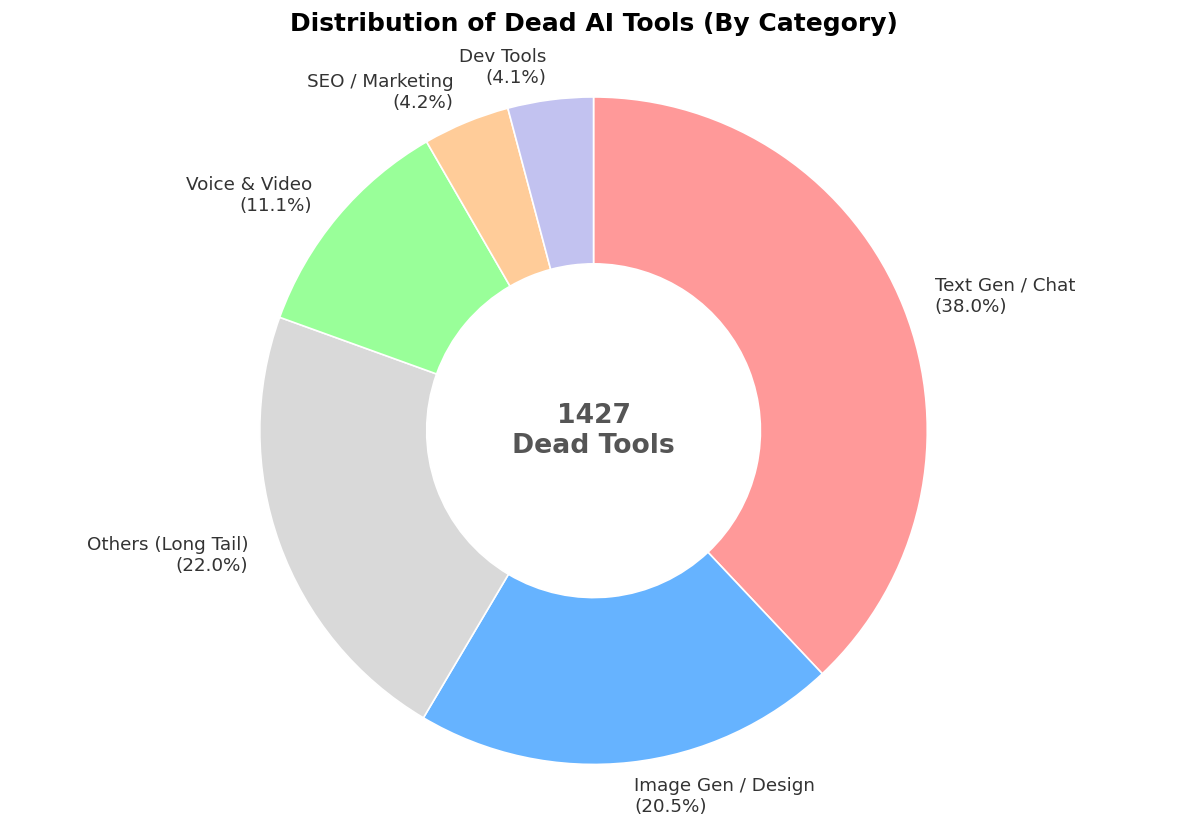

In [6]:
import matplotlib.pyplot as plt

# === 1. 数据准备 (Data Preparation) ===
# 整合后的分类标签
labels = [
    'Text Gen / Chat\n(38.0%)', 
    'Image Gen / Design\n(20.5%)', 
    'Others (Long Tail)\n(22.0%)', 
    'Voice & Video\n(11.1%)', 
    'SEO / Marketing\n(4.2%)', 
    'Dev Tools\n(4.1%)'
]

# 对应数值 (Total: 1427)
sizes = [542, 293, 314, 159, 60, 59]

# === 2. 配色方案 (Morandi Colors) ===
# 使用柔和的莫兰迪色系，看起来更高级
colors = [
    '#ff9999',  # Text - Soft Red
    '#66b3ff',  # Image - Soft Blue
    '#d9d9d9',  # Others - Grey
    '#99ff99',  # Voice - Soft Green
    '#ffcc99',  # Marketing - Soft Orange
    '#c2c2f0',  # Dev - Soft Purple
]

# === 3. 绘制环形图 (Draw Donut Chart) ===
fig, ax = plt.subplots(figsize=(10, 7), dpi=120)

# 创建环形 (width=0.5 创建空心效果)
wedges, texts = ax.pie(sizes, labels=labels, colors=colors, startangle=90,
                       counterclock=False, 
                       wedgeprops={'width': 0.5, 'edgecolor': 'white'},
                       textprops={'fontsize': 11, 'color': '#333'})

# === 4. 添加中心文本 (Center Text) ===
ax.text(0, 0, '1427\nDead Tools', 
        horizontalalignment='center', 
        verticalalignment='center', 
        fontsize=16, fontweight='bold', color='#555')

# === 5. 标题与调整 ===
plt.title('Distribution of Dead AI Tools (By Category)', fontsize=15, pad=20, fontweight='bold')
plt.axis('equal')  # 保证是正圆
plt.tight_layout()

# 展示图表
plt.show()